# Generation of QA Pairs Notebook

## Notebook Overview

This notebook leverages NLP to generate, evaluate, and refine question–answer (QA) pairs from cleantech media and patent documents, with the goal of advancing retrieval-augmented generation (RAG) systems for cleantech.

To achieve this, we employed a series of  NLP techniques and evaluation strategies:

1. Data Selection & Preparation:
We curated 50–100 relevant paragraphs from cleantech media and patent datasets, ensuring diversity and relevance to key topics..

2. QA Pair Generation:
Using large language models (LLMs), we generated fact-based QA pairs from the selected paragraphs, ensuring close alignment with the source content.

3. QA Pair Classification:
QA pairs were classified into categories (e.g., Factual, Comparative) using rule-based and embedding methods based on semantic similarity to predefined prototypes.

4. LLM-as-a-Judge Evaluation:
Recognizing that not every generated QA pair would be of equal quality, we then evaluated each pair using LLM-based critique agents. These agents assessed three key criteria:
  - Groundedness: How clearly can the question be answered based on the given context?
  - Relevance: How useful is the question for developing cleantech NLP applications?
  - Standalone Clarity: Does the question make sense independently, without needing extra context?
      
  For each criterion, the LLM provided both a numerical score (1 to 5) and detailed feedback, which helped us identify and filter out lower-quality QA pairs.

5. Filtering & Analysis:
QA pairs scoring at least 4 out of 5 on all criteria were retained, and the dataset's quality was visualized for further refinement.

## 1. Introduction & Learning Goals

We started with the goal of creating a comprehensive QA dataset from cleantech texts, extracting 50–100 high-quality paragraphs from the Cleantech Media and Google Patent datasets. These paragraphs cover various cleantech topics, ensuring diverse and relevant QA pairs.

This notebook walks you through generating high-quality QA pairs, emphasizing the importance of data quality and robust evaluation in NLP applications.

## 2. Data Preparation & Visualization

### Set the OpenRouter.api Key



In [5]:
%%writefile .env

api_key = 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

Writing .env


*Python library Installations*

In [9]:
!pip uninstall -y numpy
!pip install numpy==1.23.5

Found existing installation: numpy 2.2.4
Uninstalling numpy-2.2.4:
  Successfully uninstalled numpy-2.2.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 55.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.2.1 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, 

In [ ]:
!pip install gensim==4.3.3

In [5]:
!pip install -q tiktoken seaborn spacy langchain openai sentence-transformers python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

### Loading the Dependencies

In [3]:
import gensim
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import ast
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import tiktoken
import spacy
from openai import OpenAI
from tqdm.auto import tqdm
from typing import Optional, List, Tuple
import json
import textwrap


from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document as LangchainDocument

pd.set_option("display.max_colwidth", None)

nlp = spacy.load("en_core_web_sm")

encoding = tiktoken.encoding_for_model("gpt-4")

import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()




[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### Setting up our LLM

In [6]:
load_dotenv()

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=os.getenv("api_key"),
)

### Dataset Download

- Cleantech Media Dataset: Contains media articles focused on cleantech topics.

- Google Patent Dataset: Provides detailed patent information related to cleantech.

If using Colab, you can download these datasets directly from Kaggle (using the Kaggle API) or from provided Google Drive links. Make sure to store them in a designated folder (e.g., data/bronze).


In [7]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path_media_dataset_v3_2024_10_28 = "cleantech_media_dataset_v3_2024-10-28.csv"

articles_df  = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "jannalipenkova/cleantech-media-dataset",
  file_path_media_dataset_v3_2024_10_28,
)

file_path_media_dataset_v3_2024_09_20 = "cleantech_rag_evaluation_data_2024-09-20.csv"

human_eval = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "jannalipenkova/cleantech-media-dataset",
    file_path_media_dataset_v3_2024_09_20,
    pandas_kwargs={
        "sep": ";",
        "engine": "python",
        "encoding": "latin-1",
    }
)

# print("First 5 records:", df_media_dataset_v3_2024_09_20.head())


<ipython-input-7-8dd5952fdf74>:6: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  articles_df  = kagglehub.load_dataset(
<ipython-input-7-8dd5952fdf74>:14: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  human_eval = kagglehub.load_dataset(


In [8]:

file_paths = [
    'bq-results-20240124-055833-1706076079048.json',
    'CleanTech_22-24.json',
    'CleanTech_22-24_updated.json'
]

dfs = {}

for file_path in file_paths:
   df = kagglehub.load_dataset(
       KaggleDatasetAdapter.PANDAS,
        "prakharbhandari20/cleantech-google-patent-dataset",
        "bq-results-20240124-055833-1706076079048.json",
        pandas_kwargs={
            "lines": True,
        })
   dfs[file_path] = df



patent_df = dfs['bq-results-20240124-055833-1706076079048.json']

<ipython-input-8-c1df106e5251>:10: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(
<ipython-input-8-c1df106e5251>:10: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(
<ipython-input-8-c1df106e5251>:10: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


In [ ]:
# !curl -O https://raw.githubusercontent.com/tamannaKumavat/SwissText_Shared_Task_2025/main/data/merged_media_qa_pairs.csv
# !curl -O https://raw.githubusercontent.com/tamannaKumavat/SwissText_Shared_Task_2025/main/data/patent_dataset_qa_pairs.csv


### Text Preprocessing


In [ ]:
def preprocess_text(text, apply_stemming=False):
    """
    Preprocess a given text by:
      - Converting to lowercase
      - Tokenizing
      - Removing punctuation and stop words
      - Applying lemmatization (and optionally stemming)
    """
    if not isinstance(text, str):
        return []

    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    if apply_stemming:
        tokens = [stemmer.stem(token) for token in tokens]

    return tokens


In [ ]:
articles_df.head(2)

Unnamed: 0                                          title        date  \
0       93320      XPeng Delivered ~100,000 Vehicles In 2021  2022-01-02   
1       93321  Green Hydrogen: Drop In Bucket Or Big Splash?  2022-01-02   

   author  \
0     NaN   
1     NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
patent_df.head(2)

,publication_number,application_number,country_code,title_localized,abstract_localized,publication_date,inventor,cpc
0,US-2022239235-A1,US-202217717397-A,US,"[{'text': 'Adaptable DC-AC Inverter Drive System and Operation', 'language': 'en', 'truncated': False}]","[{'text': 'Disclosed is an adaptable DC-AC inverter system and its operation. The system includes multiple DC input sources as input to provide a stable operation under various conditions. DC input sources may be added to the system or removed from the system without impacting the functionality of the system. The disclosed system is suited for solar energy harvesting in grid-connected or off-grid modes of operation.', 'language': 'en', 'truncated': False}]",20220728,[],"[{'code': 'H02M7/5395', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02J3/32', 'inventive': False, 'first': False, 'tree': []}, {'code': 'H02M1/32', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02J1/10', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02J3/381', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02M7/493', 'inventive': True, 'first': True, 'tree': []}, {'code': 'H02J2300/24', 'inventive': False, 'first': False, 'tree': []}, {'code': 'H02J2300/30', 'inventive': False, 'first': False, 'tree': []}]"
1,US-2022239251-A1,US-202217580956-A,US,"[{'text': 'System for providing the energy from a single contiguous solar energy structure to at least two different meters', 'language': 'en', 'truncated': False}]","[{'text': 'In accordance with an example embodiment, a solar energy system comprises: a solar energy structure comprising photovoltaic solar panels contiguously covering an area; a first inverter configured to receive power from a first string of photovoltaic solar panels, wherein the first inverter is configured to provide the power received at the first inverter to a first meter; and a second inverter configured to receive power from a second string of photovoltaic solar panels, wherein the second inverter is configured to provide the power received at the second inverter to a second meter.', 'language': 'en', 'truncated': False}]",20220728,[],"[{'code': 'H02S40/38', 'inventive': True, 'first': False, 'tree': []}, {'code': 'G01R22/061', 'inventive': True, 'first': False, 'tree': []}, {'code': 'B60L53/51', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02S40/32', 'inventive': True, 'first': True, 'tree': []}]"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#### Tokenize the Title and the Context of the datasets

In [ ]:
articles_df['tokens_title'] = articles_df['title'].apply(preprocess_text)
articles_df['tokens_content'] = articles_df['content'].apply(preprocess_text)

In [ ]:
patent_df['tokens_title'] = patent_df['title_localized'].apply(
    lambda lst: preprocess_text(lst[0]['text']) if isinstance(lst, list) and lst and 'text' in lst[0] else []
)

patent_df['tokens_abstract'] = patent_df['abstract_localized'].apply(
    lambda lst: preprocess_text(lst[0]['text']) if isinstance(lst, list) and lst and 'text' in lst[0] else []
)

### Functions Definitions

In this section, we conduct exploratory data analysis to understand our dataset. Our goals include:

**Overview:**

*   Check for missing values and duplicates.

*   Inspect key columns, like the author column, for non-null entries.

*   Ensure proper dataset structure before advancing.

**Domain Analysis:**

* Identify top content publishers.

* Analyze publication trends, including article counts per domain.

* Visualize article distribution across publishers.

**Cleaning:**

* Normalize URLs for consistency.

* Remove duplicate articles.

* Standardize article formats, removing common introductions.

These steps ensure the dataset is clean and ready for QA pair generation and analysis.

We also implemented custom plotting functions to visualize the dataset:

**show_questions**: Displays the first n questions from a list for quick inspection.

**gpt4_tokenizer**: Tokenizes text with GPT-4 to analyze token distribution.

**plot_character_distribution**: Visualizes character length distribution of questions.

**plot_word_distribution**: Plots the word count distribution for questions.

**plot_gpt4_token_distribution**: Displays common tokens from questions.

**plot_non_stopword_token_distribution**: Shows non-stopword tokens to highlight subject-specific vocabulary.

**printwrap**: A helper function for better text readability in output.

In [ ]:
# plot functions

def show_questions(title: str, questions: list, n: int = 6) -> None:
    """
    Display the first n questions from the given list with a title.

    Parameters:
    - title: A string to display as the category title.
    - questions: A list of questions.
    - n: The maximum number of questions to display (default is 6).
    """
    print(title)
    print("-" * len(title))
    for idx, question in enumerate(questions[:n], start=1):
        print(f"{idx}. {question}")
    print()



def gpt4_tokenizer(text: str):
    """
    Tokenizes the text using the GPT-4 tokenizer from tiktoken.
    Returns a list of token strings.
    """
    token_ids = encoding.encode(text)
    tokens = [encoding.decode([tid]) for tid in token_ids]
    return tokens

def plot_character_distribution(df):
    """
    Plots a histogram (with KDE) of the character lengths in the 'question' column.
    Displays vertical lines for the median and mean character counts.
    """
    char_lengths = df["question"].map(len)
    sns.histplot(char_lengths, kde=True)
    plt.title("Amount of characters in questions")
    plt.xlabel("Amount of characters")
    plt.ylabel("Number of questions")

    median_char_len = char_lengths.median()
    mean_char_len = char_lengths.mean()
    plt.axvline(median_char_len, color='r', linestyle='--', label=f"Median: {median_char_len:.2f}")
    plt.axvline(mean_char_len, color='g', linestyle='--', label=f"Mean: {mean_char_len:.2f}")
    plt.legend()
    plt.show()

def plot_word_distribution(df):
    """
    Plots a histogram (with KDE) of the word counts in the 'question' column.
    Displays vertical lines for the median and mean word counts.
    """
    word_counts = df["question"].map(lambda x: len(x.split()))
    sns.histplot(word_counts, kde=True)
    plt.title("Amount of words in questions")
    plt.xlabel("Amount of words")
    plt.ylabel("Number of questions")

    median_word_count = word_counts.median()
    mean_word_count = word_counts.mean()
    plt.axvline(median_word_count, color='r', linestyle='--', label=f"Median: {median_word_count:.2f}")
    plt.axvline(mean_word_count, color='g', linestyle='--', label=f"Mean: {mean_word_count:.2f}")
    plt.legend()
    plt.show()

def plot_gpt4_token_distribution(df):
    """
    Uses the GPT-4 tokenizer to tokenize the 'question' column,
    filters out non-alphabetic tokens, counts the top 20 most common tokens,
    and displays a horizontal barplot.
    """
    questions = df['question'].tolist()

    all_tokens = [token for question in questions for token in gpt4_tokenizer(question)]

    alpha_tokens = [token.strip().lower() for token in all_tokens if token.strip().isalpha()]

    alpha_token_counts = Counter(alpha_tokens)
    top_tokens = alpha_token_counts.most_common(20)

    if top_tokens:
        tokens, counts = zip(*top_tokens)
        sns.barplot(x=list(counts), y=list(tokens))
        plt.title("Most common alphabetic tokens")
        plt.xlabel("Count")
        plt.ylabel("Token")
        plt.show()
    else:
        print("No tokens found after filtering.")

def plot_non_stopword_token_distribution(df):
    """
    Uses the GPT-4 tokenizer to tokenize the 'question' column,
    filters out non-alphabetic tokens and then filters out stopwords using spaCy.
    It then counts the top 20 most common non-stopword tokens and displays a horizontal barplot.
    """
    questions = df['question'].tolist()

    all_tokens = [token for question in questions for token in gpt4_tokenizer(question)]
    alpha_tokens = [token.strip().lower() for token in all_tokens if token.strip().isalpha()]
    non_stop_tokens = [token for token in alpha_tokens if not nlp.vocab[token].is_stop]
    non_stop_token_counts = Counter(non_stop_tokens)
    top_tokens = non_stop_token_counts.most_common(20)

    if top_tokens:
        tokens, counts = zip(*top_tokens)
        sns.barplot(x=list(counts), y=list(tokens))
        plt.title("Most common non-stopword tokens")
        plt.xlabel("Count")
        plt.ylabel("Token")
        plt.show()
    else:
        print("No non-stop tokens found after filtering.")

def printwrap(text, wrap_lenght = 80):
  wrapped_text = textwrap.fill(text,wrap_lenght)
  return wrapped_text

**Overview:**
We examine the dataset for missing values and duplicates, identifying problematic columns such as sparsely populated author fields.

**Domain Analysis:**
We analyze the distribution of articles across publishers to understand domain dominance, which aids in decisions like stratified subsampling.

**Cleaning:**
We normalize URLs, remove duplicates, and standardize article formats by removing redundant sections from web scraping.

**Plotting Functions:**
Custom plots visualize:

- The length of questions in terms of characters and words.
- The most common tokens overall and non-stopword tokens using the GPT-4 tokenizer.


### Selection of Important Paragraphs
To generate robust QA pairs, we first identified key paragraphs in our dataset. We selected paragraphs based on relevance, informativeness, and their potential to generate high-quality questions and answers.

***Process Overview:***

  - **Domain Filtering:**
    We separated the data into 5 domains: "azocleantech", "solarindustrymag", "cleantechnica", "pv-magazine", and "energyvoice", ensuring relevance to our project.

  - **Manual Selection by Index:**
    After filtering by domain, we manually selected high-quality paragraphs based on content. For example, we selected 7 paragraphs from "azocleantech" and 8 from "solarindustrymag", saving them in a CSV file. These selections cover diverse cleantech topics to ensure varied input for QA generation.

  - **Language Filter:**
    We focused exclusively on English examples for consistency with the tutorial's approach. For more details, refer to the [Cleantech RAG Tutorial](https://github.com/LuciferUchiha/Cleantech-RAG/blob/main/cleantech_rag.ipynb).


In [ ]:
azocleantech_df = articles_df[articles_df['domain']=='azocleantech']

In [ ]:
solarindustrymag_df = articles_df[articles_df['domain']=='solarindustrymag']

In [ ]:
pv_magazine_df = articles_df[articles_df['domain']=='pv-magazine']

In [ ]:
energyvoice_df = articles_df[articles_df['domain']=='energyvoice']

In [ ]:
cleantechnica_df = articles_df[articles_df['domain']=='cleantechnica']

###Paragraphs for azocleantech domain

In [ ]:
# 7 paragraphs of azocleantech_df
selected_indices = [17690, 17915, 18349, 17715, 19247, 15788, 2195]
paragraphs_azocleantech_df = azocleantech_df.loc[selected_indices]

###Paragraphs for solarindustrymag domain

In [ ]:
# 8 paragraphs of solarindustrymag_df

selected_indices = [14,4307,1513,2216,13545,13382,2344,1578]
paragraphs_solarindustrymag_df = solarindustrymag_df.loc[selected_indices]

###Paragraphs for pv-magzine domain

In [ ]:
pv_magazine_indices=[1311, 1416, 14590, 16840, 17599, 17643, 18321, 18854, 18906, 19194]
paragraphs_pv_magazine_df = pv_magazine_df.loc[pv_magazine_indices]


[1311, 1416, 14590, 16840, 17599, 17643, 18321, 18854, 18906, 19194]

###Paragraphs for energyvoice domain

In [ ]:
energyvoice_indices=[870, 2204, 2979, 3255, 4605, 5268, 6320, 12599, 12647, 18538]
paragraphs_energyvoice_df = energyvoice_df.loc[energyvoice_indices]

###Paragraphs for cleantechnica domain

In [ ]:
filtered_indices = cleantechnica_df.index[cleantechnica_df["Unnamed: 0"].isin(
    [95438, 95392, 95363, 95261, 95173, 95163, 95133, 95106,
     95074, 94927, 94925, 94662, 94668, 94645, 95411]
)].tolist()

In [ ]:
paragraphs_cleantechnica_df = cleantechnica_df.loc[filtered_indices]

In [ ]:
combined_df = pd.concat([paragraphs_azocleantech_df,
                         paragraphs_solarindustrymag_df,
                         paragraphs_pv_magazine_df,
                         paragraphs_energyvoice_df,
                         paragraphs_cleantechnica_df],
                        ignore_index=True)

In [ ]:
combined_df.to_csv("/content/drive/MyDrive/SwissText_SharedTask/paragraphs_media_dataset.csv")

In [ ]:
combined_df.head()

Unnamed: 0.1  Unnamed: 0  \
0             0       23302   
1             1       23338   
2             2       23355   
3             3       23307   
4             4       23380   

                                                                           title  \
0                      Renewable Energy Partnerships: Green Hydrogen Integration   
1  Asahi Kasei Starts Operation of Multi-Module Hydrogen Pilot Plant in Kawasaki   
2                                Global Warming Threatens Hudson Bay Polar Bears   
3                              Efficient Recycling Key to Widespread EV Adoption   
4              Multi-Junction Solar Cells Offer a New Path to Sustainable Energy   

         date  author  \
0  2024-05-01     NaN   
1  2024-05-15     NaN   
2  2024-06-14     NaN   
3  2024-05-02     NaN   
4  2024-08-12     NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

## 3. QA Pair Generation

We use the Llama 3.2 Instruct model to generate QA pairs from selected paragraphs. Each generated question and answer is tied to specific cleantech-related content, providing context for later analysis.

For the **media dataset**, the QA pairs include:

  - **question**: The generated question.
  - **relevant_text**: The text (paragraph) used as context.
  - **answer**: The generated answer.
  - **article_url**: The URL of the source article.

For the **patent dataset**, the QA pairs contain additional metadata:

  - **question**: The generated question.
  - **relevant_text**: The abstract used as context.
  - **answer**: The generated answer.
  - **title**: The patent title.
  - **publication_date**: The patent publication date.
  - **inventor**: The inventor(s) associated with the patent.

Below is the updated function. It accepts an additional argument `dataset_type`, specifying whether the DataFrame is from the media dataset ("media") or from the patent dataset ("patent"). Depending on the value, the function appends the appropriate metadata to each QA pair.


In [ ]:
from openai import OpenAI
import pandas as pd
import re

def generate_qa_pairs(df, target_qa_pairs=43, dataset_type="media"):
    """
    Generates QA pairs from a given DataFrame using Llama 3.2 Instruct.

    Parameters:
      df (pd.DataFrame): DataFrame containing the reference texts.
         For the media dataset, it is expected to have a 'content' column and 'url'.
         For the patent dataset, it is expected to have an 'abstract' column, 'title',
         'publication_date', and 'inventor'.
      target_qa_pairs (int): The target number of QA pairs to generate.
      dataset_type (str): Specifies the dataset type. Use "media" for the media dataset,
         and "patent" for the patent dataset.

    Returns:
      pd.DataFrame: DataFrame containing the generated QA pairs and the associated metadata.
    """
    qa_pairs = []

    for _, row in df.iterrows():
        if dataset_type.lower() == "media":
            context_text = row['content']
        elif dataset_type.lower() == "patent":
            context_text = row['abstract']
        else:
            raise ValueError("dataset_type must be either 'media' or 'patent'.")

        paragraphs = context_text.split("\n\n")

        for paragraph in paragraphs:
            if not paragraph.strip():
                continue

            prompt = (
            "Using the following text, generate 15 unique and meaningful question–answer pairs.\n\n"
            "Instructions:\n"
            "1. Questions should be varied: include what, who, when, where, why, and how as appropriate.\n"
            "2. Focus on important details, facts, or concepts mentioned in the text.\n"
            "3. Provide clear answers that explain the key idea without being overly brief or too long.\n"
            "4. Format each pair as follows:\n"
            "Q: [Your question here]\n"
            "A: [Your answer here]\n\n"
            "Separate each Q&A pair with a blank line.\n\n"
            f"Text:\n{paragraph.strip()}"
        )


            try:
                completion = client.chat.completions.create(
                    model="meta-llama/llama-3.2-3b-instruct",
                    messages=[{"role": "user", "content": prompt}],
                )

                response = completion.choices[0].message.content.strip()

                # Extract Q&A pairs from the response
                qa_text = re.findall(r"Q:\s*(.*?)\s*A:\s*(.*?)(?=\nQ:|\Z)", response, re.DOTALL)

                for question, answer in qa_text:
                    if not any(existing["question"] == question for existing in qa_pairs):
                        if dataset_type.lower() == "media":
                            qa_pair = {
                                "question": question.strip(),
                                "relevant_text": paragraph.strip(),
                                "answer": answer.strip(),
                                "article_url": row.get('url', '')
                            }
                        else:
                            qa_pair = {
                                "question": question.strip(),
                                "relevant_text": paragraph.strip(),
                                "answer": answer.strip(),
                                "title": row.get('title', ''),
                                "publication_date": row.get('publication_date', ''),
                                "inventor": row.get('inventor', '')
                            }

                        qa_pairs.append(qa_pair)

                    if len(qa_pairs) >= target_qa_pairs:
                        break

            except Exception as e:
                print(f"Error: {e}")
                continue

        if len(qa_pairs) >= target_qa_pairs:
            break

    return pd.DataFrame(qa_pairs)


In [ ]:
combined_qa_df = generate_qa_pairs(combined_df, target_qa_pairs=800, dataset_type="media")
combined_qa_df.to_csv("/content/drive/MyDrive/SwissText_SharedTask/combined_media_qa_pairs.csv", index= False)
combined_qa_df.head()

In [ ]:
combined_qa_df.head(2)

question  \
0                                              What is green hydrogen, and how is it produced?   
1  Who are some of the key players involved in the development and adoption of green hydrogen?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

### Generate the QA Pairs for the Patent Dataset
For the patent dataset, we begin by filtering the articles based on keywords relevant to cleantech (using two keyword sets for azocleantech and solarindustrymag). Patents do not come pre-categorized into domains like media articles, so we must generate QA pairs first and then apply a separate categorization process.

To extract patents relevant to cleantech topics, we use a deterministic, rule-based approach.

- We start by defining two lists of keywords:
- Next, we apply these lists to the patent dataset by examining the abstract field of each patent. Using a lambda function with the apply method, we deterministically check if any keyword exists in an abstract. This yields two Boolean masks indicating whether a patent belongs to the azocleantech or solarindustrymag domain, respectively. We then filter the dataset based on these masks.
- We decided to use a deterministic, rule-based approach because we can directly see which keywords triggered the classification, allowing us to easily audit and refine our keyword lists if needed.
- However, we are aware that this method is rigid, so if an abstract uses synonyms or slightly different phrasing that isn’t in our keyword list, it might not be classified correctly. The approach does not consider context or the possibility of words having multiple meanings. An abstract might mention a keyword in a context that does not pertain to cleantech.

By using this deterministic approach, we ensure that our patent dataset is filtered in a consistent and transparent manner. While this method is efficient and straightforward, it does have limitations regarding flexibility and nuance.

In [ ]:
# patent_df = pd.read_csv("/content/drive/MyDrive/SwissText SharedTask/dfs_google_patent.csv")

In [10]:
patent_df.head()

,publication_number,application_number,country_code,title_localized,abstract_localized,publication_date,inventor,cpc
0,US-2022239235-A1,US-202217717397-A,US,"[{'text': 'Adaptable DC-AC Inverter Drive System and Operation', 'language': 'en', 'truncated': False}]","[{'text': 'Disclosed is an adaptable DC-AC inverter system and its operation. The system includes multiple DC input sources as input to provide a stable operation under various conditions. DC input sources may be added to the system or removed from the system without impacting the functionality of the system. The disclosed system is suited for solar energy harvesting in grid-connected or off-grid modes of operation.', 'language': 'en', 'truncated': False}]",20220728,[],"[{'code': 'H02M7/5395', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02J3/32', 'inventive': False, 'first': False, 'tree': []}, {'code': 'H02M1/32', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02J1/10', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02J3/381', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02M7/493', 'inventive': True, 'first': True, 'tree': []}, {'code': 'H02J2300/24', 'inventive': False, 'first': False, 'tree': []}, {'code': 'H02J2300/30', 'inventive': False, 'first': False, 'tree': []}]"
1,US-2022239251-A1,US-202217580956-A,US,"[{'text': 'System for providing the energy from a single contiguous solar energy structure to at least two different meters', 'language': 'en', 'truncated': False}]","[{'text': 'In accordance with an example embodiment, a solar energy system comprises: a solar energy structure comprising photovoltaic solar panels contiguously covering an area; a first inverter configured to receive power from a first string of photovoltaic solar panels, wherein the first inverter is configured to provide the power received at the first inverter to a first meter; and a second inverter configured to receive power from a second string of photovoltaic solar panels, wherein the second inverter is configured to provide the power received at the second inverter to a second meter.', 'language': 'en', 'truncated': False}]",20220728,[],"[{'code': 'H02S40/38', 'inventive': True, 'first': False, 'tree': []}, {'code': 'G01R22/061', 'inventive': True, 'first': False, 'tree': []}, {'code': 'B60L53/51', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02S40/32', 'inventive': True, 'first': True, 'tree': []}]"
2,EP-4033090-A1,EP-21152924-A,EP,"[{'text': 'Verfahren zum steuern einer windenergieanlage', 'language': 'de', 'truncated': False}, {'text': 'Method for controlling a wind energy system', 'language': 'en', 'truncated': False}, {'text': 'Procédé de commande d&#39;une éolienne', 'language': 'fr', 'truncated': False}]","[{'text': 'Verfahren zum Steuern einer Windenergieanlage (100), wobei die Windenergieanlage (100) einen aerodynamischen Rotor (106) aufweist, der mit variabler Drehzahl betrieben wird, und der in ihrem Blattwinkel verstellbare Rotorblätter (108) ausweist, wobei die Windenergieanlage (100) in einem Teillastbereich durch eine Betriebskennliniensteuerung gesteuert wird, die eine Betriebskennlinie verwendet, wobei die Betriebskennlinie (402) einen Zusammenhang zwischen der Drehzahl und einer einzustellenden Generatorzustandsgröße vorgibt, wobei die einzustellende Generatorzustandsgröße eine Generatorleistung oder ein Generatormoment ist, und die Betriebskennliniensteuerung so erfolgt, dass in Abhängigkeit von einer erfassten Drehzahl ein durch die Betriebskennlinie vorgegebener Wert der Generatorzustandsgröße eingestellt wird, und die Windenergieanlage in einem Volllastbereich, durch eine Pitchregelung (304) geregelt wird, bei der die Drehzahl durch Verstellen der Blattwinkel auf einen Drehzahlsollwert geregelt wird, wobei in wenigstens einem vorgebbaren Drehzahlbereich des Teillastbereichs, und/oder in einem Übergangsbereich vom Teillastbereich zum Volllastbereich die Windenergieanlage durch eine Drehzahlleistungsr

In [14]:
patent_df['title_lang'] = patent_df['title_localized'].apply(lambda x:x[0]['language'])
patent_df['abstract_lang'] = patent_df['abstract_localized'].apply(lambda x:x[0]['language'])

patent_df['title_text'] = patent_df['title_localized'].apply(lambda x:x[0]['text'])
patent_df['abstract_text'] = patent_df['abstract_localized'].apply(lambda x:x[0]['text'])

patent_df['total'] = patent_df['title_text']+patent_df['abstract_text']

In [15]:
patent_df['w_count'] = patent_df['total'].apply(lambda x:len(x.split()))

In [16]:
patent_df.head(2)

,publication_number,application_number,country_code,title_localized,abstract_localized,publication_date,inventor,cpc,title_lang,abstract_lang,title_text,abstract_text,total,w_count
0,US-2022239235-A1,US-202217717397-A,US,"[{'text': 'Adaptable DC-AC Inverter Drive System and Operation', 'language': 'en', 'truncated': False}]","[{'text': 'Disclosed is an adaptable DC-AC inverter system and its operation. The system includes multiple DC input sources as input to provide a stable operation under various conditions. DC input sources may be added to the system or removed from the system without impacting the functionality of the system. The disclosed system is suited for solar energy harvesting in grid-connected or off-grid modes of operation.', 'language': 'en', 'truncated': False}]",20220728,[],"[{'code': 'H02M7/5395', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02J3/32', 'inventive': False, 'first': False, 'tree': []}, {'code': 'H02M1/32', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02J1/10', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02J3/381', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02M7/493', 'inventive': True, 'first': True, 'tree': []}, {'code': 'H02J2300/24', 'inventive': False, 'first': False, 'tree': []}, {'code': 'H02J2300/30', 'inventive': False, 'first': False, 'tree': []}]",en,en,Adaptable DC-AC Inverter Drive System and Operation,Disclosed is an adaptable DC-AC inverter system and its operation. The system includes multiple DC input sources as input to provide a stable operation under various conditions. DC input sources may be added to the system or removed from the system without impacting the functionality of the system. The disclosed system is suited for solar energy harvesting in grid-connected or off-grid modes of operation.,Adaptable DC-AC Inverter Drive System and OperationDisclosed is an adaptable DC-AC inverter system and its operation. The system includes multiple DC input sources as input to provide a stable operation under various conditions. DC input sources may be added to the system or removed from the system without impacting the functionality of the system. The disclosed system is suited for solar energy harvesting in grid-connected or off-grid modes of operation.,70
1,US-2022239251-A1,US-202217580956-A,US,"[{'text': 'System for providing the energy from a single contiguous solar energy structure to at least two different meters', 'language': 'en', 'truncated': False}]","[{'text': 'In accordance with an example embodiment, a solar energy system comprises: a solar energy structure comprising photovoltaic solar panels contiguously covering an area; a first inverter configured to receive power from a first string of photovoltaic solar panels, wherein the first inverter is configured to provide the power received at the first inverter to a first meter; and a second inverter configured to receive power from a second string of photovoltaic solar panels, wherein the second inverter is configured to provide the power received at the second inverter to a second meter.', 'language': 'en', 'truncated': False}]",20220728,[],"[{'code': 'H02S40/38', 'inventive': True, 'first': False, 'tree': []}, {'code': 'G01R22/061', 'inventive': True, 'first': False, 'tree': []}, {'code': 'B60L53/51', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02S40/32', 'inventive': True, 'first': True, 'tree': []}]",en,en,System for providing the energy from a single contiguous solar energy structure to at least two different meters,"In accordance with an example embodiment, a solar energy system comprises: a solar energy structure comprising photovoltaic solar panels contiguously covering an area; a first inverter configured to receive power from a first string of photovoltaic solar panels, wherein the first inverter is configured to provide the power received at the first inverter to a first meter; and a second inverter configured to receive power from a secon

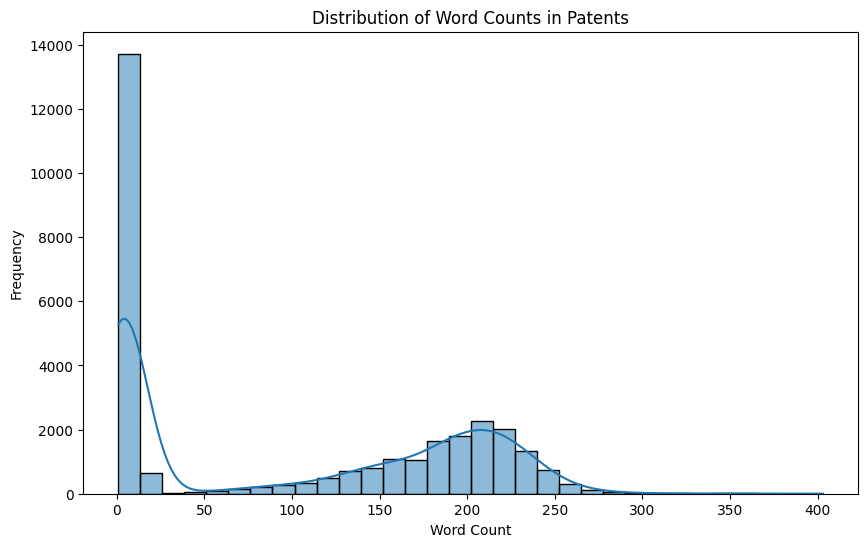

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(patent_df['w_count'], kde=True)
plt.title('Distribution of Word Counts in Patents')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


In [19]:
display(patent_df[['title_lang','abstract_lang']].value_counts())


,,count
title_lang,abstract_lang,
en,en,8297
zh,zh,7741
en,zh,6624
zh,en,6463
fr,en,226
de,en,128
en,fr,126
fr,fr,64
de,de,38


### enteries with more that 20 tokens are 15673 out of 30000

In [33]:
clean_patent_df = patent_df[(patent_df['title_lang'] == 'en')*(patent_df['abstract_lang'] == 'en')*(patent_df['w_count']>20)]


In [34]:
len(clean_patent_df)

8296

In [35]:
# prompt: apply topic modeling on patent_df['total'] LDA
# fined topic of each document

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

# Preprocess the text data
def preprocess(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 3:
            result.append(token)
    return result

clean_patent_df['clean_total'] = clean_patent_df['total'].apply(preprocess)
processed_docs = clean_patent_df['clean_total']

# Create a dictionary and corpus
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Apply LDA topic modeling
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=10, passes=2, workers=4)

# Print the top words for each topic
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}\n")

# Find the dominant topic for each document
for index, row in clean_patent_df.iterrows():
    bow = dictionary.doc2bow(row['clean_total'])
    dominant_topic = max(lda_model[bow], key=lambda item: item[1])
    # print(f"Document {index}: Dominant Topic - {dominant_topic}")


<ipython-input-35-20247364acb5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_patent_df['clean_total'] = clean_patent_df['total'].apply(preprocess)


Topic: 0 
Words: 0.026*"solar" + 0.016*"energy" + 0.016*"body" + 0.014*"model" + 0.012*"utility" + 0.012*"mounting" + 0.012*"fixed" + 0.011*"light" + 0.011*"battery" + 0.011*"discloses"

Topic: 1 
Words: 0.030*"energy" + 0.019*"device" + 0.017*"wind" + 0.015*"solar" + 0.014*"connected" + 0.012*"water" + 0.011*"arranged" + 0.011*"power" + 0.010*"plate" + 0.009*"model"

Topic: 2 
Words: 0.021*"solar" + 0.014*"body" + 0.014*"arranged" + 0.013*"lamp" + 0.013*"device" + 0.011*"water" + 0.011*"utility" + 0.010*"panel" + 0.010*"energy" + 0.010*"model"

Topic: 3 
Words: 0.022*"solar" + 0.021*"body" + 0.020*"plate" + 0.019*"layer" + 0.014*"energy" + 0.011*"structure" + 0.011*"water" + 0.010*"arranged" + 0.009*"comprises" + 0.008*"second"

Topic: 4 
Words: 0.024*"solar" + 0.012*"heat" + 0.012*"energy" + 0.011*"water" + 0.011*"wall" + 0.009*"method" + 0.008*"temperature" + 0.008*"arranged" + 0.008*"power" + 0.008*"panel"

Topic: 5 
Words: 0.017*"solar" + 0.017*"energy" + 0.014*"water" + 0.014*"mo

In [36]:
def get_top_words_and_docs(lda_model, corpus, dictionary, num_topics=10, top_words=10, top_docs=5):
    topic_results = []
    for topic_idx in range(num_topics):
        # Get top words for the topic
        top_words_for_topic = [word for word, prob in lda_model.show_topic(topic_idx, top_words)]

        # Get the documents with the highest probability for this topic
        topic_document_probs = []  # List to store document probabilities for this topic
        for doc_idx, doc_bow in enumerate(corpus):
          for topic_prob_idx, topic_prob in lda_model[doc_bow]:
            if topic_prob_idx == topic_idx:
              topic_document_probs.append((doc_idx, topic_prob))
              break  # Move on to next document

        topic_document_probs.sort(key = lambda x: x[1], reverse=True)  # Sort in descending order based on probability

        top_docs_for_topic = [doc_idx for doc_idx, _ in topic_document_probs[:top_docs]]


        topic_results.append({
            'topic_id': topic_idx,
            'top_words': top_words_for_topic,
            'top_documents': top_docs_for_topic
        })
    return topic_results


topic_results = get_top_words_and_docs(lda_model, corpus, dictionary)
document_indices = []
for topic in topic_results:
  print(f"Topic {topic['topic_id']}:")
  print("Top Words:", topic['top_words'])
  print("Top Documents:", topic['top_documents'])
  document_indices.extend(topic['top_documents'])
  print("-"*20)


Topic 0:
Top Words: ['solar', 'energy', 'body', 'model', 'utility', 'mounting', 'fixed', 'light', 'battery', 'discloses']
Top Documents: [8065, 8066, 7445, 7447, 8061]
--------------------
Topic 1:
Top Words: ['energy', 'device', 'wind', 'solar', 'connected', 'water', 'arranged', 'power', 'plate', 'model']
Top Documents: [6715, 6701, 5092, 5091, 4080]
--------------------
Topic 2:
Top Words: ['solar', 'body', 'arranged', 'lamp', 'device', 'water', 'utility', 'panel', 'energy', 'model']
Top Documents: [7783, 7877, 6291, 6293, 4146]
--------------------
Topic 3:
Top Words: ['solar', 'body', 'plate', 'layer', 'energy', 'structure', 'water', 'arranged', 'comprises', 'second']
Top Documents: [5136, 5137, 6703, 6707, 6716]
--------------------
Topic 4:
Top Words: ['solar', 'heat', 'energy', 'water', 'wall', 'method', 'temperature', 'arranged', 'power', 'panel']
Top Documents: [482, 530, 552, 2289, 2291]
--------------------
Topic 5:
Top Words: ['solar', 'energy', 'water', 'model', 'fixed', '

In [37]:
patent_df_selected_abstracts = clean_patent_df.iloc[document_indices]
patent_df_selected_abstracts

,publication_number,application_number,country_code,title_localized,abstract_localized,publication_date,inventor,cpc,title_lang,abstract_lang,title_text,abstract_text,total,w_count,clean_total
29158,CN-214884946-U,CN-202120231657-U,CN,"[{'text': 'House roof tile combines solar hot water pipe tile', 'language': 'en', 'truncated': False}, {'text': '一种房屋顶瓦结合太阳能热水管瓦', 'language': 'zh', 'truncated': False}]","[{'text': 'The utility model discloses a house roof tile combined with a solar hot water pipe tile, which comprises a tile body, a lower fixing plate, an upper fixing plate and a fixing unit; the upper end of the tile body is fixedly connected with a lower fixing plate; the lower end of the tile body is fixedly connected with an upper fixing plate; the lower fixing plate and the upper fixing plate are provided with fixing units; the fixed unit comprises a lower perforation groove, a heat collecting pipe groove and an upper perforation groove; the lower perforated groove is formed in the lower fixing plate; the upper perforated groove is arranged on the upper fixing plate; the upper perforation groove is formed on the tile body; through the structural design of the tile body, the lower perforated groove, the heat collecting pipe groove, the reflective heat collecting film and the upper perforated groove, the functions of directly fastening and fixing with the heat collecting pipe and high light concentration and heat collection are realized, the problem that the traditional solar energy can only receive light on one side for heat collection is solved, and the heat collecting efficiency is improved; the problem of traditional solar rack life not long and the focus is high unstable in strong wind is solved, life and the anti-wind ability of solar energy have been improved.', 'language': 'en', 'truncated': False}, {'text': '本实用公开了一种房屋顶瓦结合太阳能热水管瓦，包括瓦本体、下固定板、上固定板和固定单元；所述瓦本体的上端固接有下固定板；所述瓦本体的下端固接有上固定板；所述下固定板和上固定板上设有固定单元；所述固定单元包括下穿孔槽、集热管凹槽和上穿孔槽；所述下穿孔槽开设于下固定板；所述上穿孔槽开设于上固定板上；所述上穿孔槽开设于瓦本体上；通过瓦本体、下穿孔槽、集热管凹槽、反光集热膜和上穿孔槽的结构设计,实现了直接与集热管扣合固定且高聚光聚热的功能，解决了传统的太阳能只能接收一面光照集热的问题，提高了集热的效率；解决了传统的太阳能支架使用寿命不长且重心高在大风中不稳定的问题，提高了太阳能的使用寿命和抗风能力。', 'language': 'zh', 'truncated': False}]",20211126,[LING FEI],"[{'code': 'Y02E10/47', 'inventive': False, 'first': False, 'tree': []}, {'code': 'Y02B10/20', 'inventive': False, 'first': False, 'tree': []}, {'code': 'Y02E10/44', 'inventive': False, 'first': False, 'tree': []}]",en,en,House roof tile combines solar hot water pipe tile,"The utility model discloses a house roof tile combined with a solar hot water pipe tile, which comprises a tile body, a lower fixing plate, an upper fixing plate and a fixing unit; the upper end of the tile body is fixedly connected with a lower fixing plate; the lower end of the tile body is fixedly connected with an upper fixing plate; the lower fixing plate and the upper fixing plate are provided with fixing units; the fixed unit comprises a lower perforation groove, a heat collecting pipe groove and an upper perforation groove; the lower perforated groove is formed in the lower fixing plate; the upper perforated groove is arranged on the upper fixing plate; the upper perforation groove is formed on the tile body; through the structural design of the tile body, the lower perforated groove, the heat collecting pipe groove, the reflective heat collecting film and the upper perforated groove, the functions of directly fastening and fixing with the heat collecting pipe and high light concentration and heat collection are realized, the problem that the traditional solar energy can only receive light on one side for heat collection is solved, and the heat collecting efficiency is improved; the problem of traditional solar rack life not long and the focus is high unstable in strong wind is solved, life and the anti-wind ability of solar energy have been improved.","House roof tile combines solar hot water pipe tileThe utility model discloses a house roof tile combined with a solar hot water p

In [ ]:
patent_df_selected_abstracts.to_csv('patent_df_selected_abstracts.csv',index=False)

In [ ]:
import json
import re


def extract_json_from_text(text):
    # Try to find the JSON block (between the first [ and last ])
    match = re.search(r"\[\s*{.*?}\s*]", text, re.DOTALL)
    if match:
        return match.group(0)
    else:
        return None

def generate_qa_pairs(df, target_qa_pairs=43):
    qa_pairs = []
    for _ in range(target_qa_pairs):
      for _, row in tqdm(df.iterrows()):
          abstract = row['total']
          prompt = f"""
          You are a helpful assistant. Extract exactly 3 useful and meaningful question and answer pairs from the following text:


          {abstract}


          Return your answer in this JSON format:
        [
          {{
            "question": "Your first question?",
            "answer": "The answer to the first question."
          }},
          {{
            "question": "Your second question?",
            "answer": "The answer to the second question."
          }},
          {{
            "question": "Your third question?",
            "answer": "The answer to the third question."
          }}
        ]
          """
          # try:
          response = client.chat.completions.create(
            model="meta-llama/llama-3.2-3b-instruct",
            messages=[{"role": "user", "content": prompt}]
          )

          response_text = response.choices[0].message.content
          json_block = extract_json_from_text(response_text)
          if not json_block:
              print("❌ Could not find JSON in response:")
              print(response_text)
              continue

          try:
              qa_list = json.loads(json_block)
              for qa in qa_list:
                  qa_pairs.append({
                      "question": qa["question"],
                      "answer": qa["answer"],
                      "relevant_text": abstract,
                      "title": row["title"],
                      "publication_date": row["publication_date"],
                      "inventor": row["inventor"]
                  })
          except json.JSONDecodeError:
              print("❌ JSON parsing failed. Here's what the model returned:")
              print(json_block)
              continue
    return pd.DataFrame(qa_pairs)

In [ ]:
patent_df_related = pd.read_csv('patent_df_selected_abstracts.csv')

In [ ]:
patents_qa_df = generate_qa_pairs(patent_df_related, target_qa_pairs=4)

In [ ]:
patents_qa_df

In [ ]:
patents_qa_df.to_csv('patents_qa_df_510.csv', index=False)

## 4. QA Pair Classification

After generating our QA pairs, our next step is to classify each question into a category. This categorization is essential to ensure that our QA pairs cover diverse aspects of cleantech, such as factual details, comparative market analysis, analytical explanations, government or corporate initiatives, and sustainability or technological innovations.

For each generated QA pair, we want to automatically determine the most suitable category based on the question's content. We experimented with two methods:

  -  A Rule-Based Approach:

        This method involves defining a dictionary of categories along with associated keywords. For each question, we count the occurrences of each keyword corresponding to every category. The category with the highest score is assigned to the question.
        It is easily interpretable since we can trace the category decision to keyword matches. However, it is limited flexibility if questions use synonyms or varied phrasing that is not in the keyword list.

  - BERT Sentence Approach:
    In this approach, we use a SentenceTransformer model to encode each generated question into an embedding vector. We then compare these embeddings to precomputed embeddings of category prototype texts (i.e., descriptions of what each category should capture) using cosine similarity. The category with the highest similarity score is assigned to the question.
    In this approach, Tthe quality of classification heavily depends on the choice of the prototype texts and the underlying model.
    We have evaluated both methods and found that the BERT sentence approach outperformed the rule-based method. For patent questions, we even experimented with replacing the  [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) model with the [AI-Growth-Lab/PatentSBERTa](https://github.com/AI-Growth-Lab/PatentSBERTa) model, which gave even better results in capturing nuanced technical details.



### The rule based approach

In [ ]:

# solarindustry_qa_df, azocleantech_qa_df, solarindustry_patents_qa_df, azocleantech_patents_qa_df

def classify_question_rule_based(question, categories):
    question_lower = question.lower()
    scores = {cat: 0 for cat in categories}
    for cat, keywords in categories.items():
        for kw in keywords:
            if kw in question_lower:
                scores[cat] += 1
    return max(scores, key=scores.get)

categories = {
    "Factual Questions": ["what", "when", "where", "who", "which", "fact"],
    "Comparative & Market Analysis Questions": ["compare", "contrast", "market", "trend", "analysis"],
    "Analytical & Explanatory Questions": ["why", "how", "explain", "impact"],
    "Government & Corporate Initiatives": ["government", "policy", "corporate", "initiative", "regulation"],
    "Sustainability & Technological Innovation Questions": ["sustainable", "innovation", "technology", "renewable", "eco-friendly"]
}

def stack_and_categorize(dfs, categories):
    df_combined = pd.concat(dfs, ignore_index=True)
    df_combined['category'] = df_combined['question'].apply(lambda q: classify_question_rule_based(q, categories))
    return df_combined




In [ ]:

dfs = [solarindustrymag_qa_df, solarindustrymag_qa_df, solarindustry_patents_qa_df, azocleantech_patents_qa_df]

df_categorized_rule_based = stack_and_categorize(dfs, categories)

print(df_categorized_rule_based.head())

### The Sentence transformer approach

#### The all-MiniLM-L6-v2 approach

In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch

prototypes = {
    "Factual Questions": "Questions that ask for specific facts or details.",
    "Comparative & Market Analysis Questions": "Questions that compare options or analyze market trends.",
    "Analytical & Explanatory Questions": "Questions that require detailed analysis or explanation.",
    "Government & Corporate Initiatives": "Questions related to government policies or corporate initiatives.",
    "Sustainability & Technological Innovation Questions": "Questions focusing on sustainability and innovative technology."
}

model = SentenceTransformer('all-MiniLM-L6-v2')

prototype_texts = list(prototypes.values())
prototype_labels = list(prototypes.keys())
prototype_embeddings = model.encode(prototype_texts, convert_to_tensor=True)

def classify_question_embedding(question: str) -> str:
    """
    Classify a question into one of the five categories using cosine similarity
    between its embedding and the precomputed prototype embeddings.
    """
    question_embedding = model.encode(question, convert_to_tensor=True)
    cosine_scores = util.cos_sim(question_embedding, prototype_embeddings)
    best_idx = torch.argmax(cosine_scores).item()
    return prototype_labels[best_idx]

def stack_and_categorize(dfs: list) -> pd.DataFrame:
    """
    Stack multiple DataFrames and add a new 'category' column by classifying each question.
    """
    df_combined = pd.concat(dfs, ignore_index=True)
    df_combined['category'] = df_combined['question'].apply(lambda q: classify_question_embedding(q))
    return df_combined



dfs = [
    solarindustrymag_qa_df,
    solarindustrymag_qa_df,
    solarindustry_patents_qa_df,
    azocleantech_patents_qa_df
]

df_categorized_sentence_bert = stack_and_categorize(dfs)


In [ ]:
df_categorized_sentence_bert

#### The AI-Growth-Lab/PatentSBERTa approach

In [ ]:

model = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')

prototype_texts = list(prototypes.values())
prototype_labels = list(prototypes.keys())
prototype_embeddings = model.encode(prototype_texts, convert_to_tensor=True)


df_categorized_patent_sentence_bert = stack_and_categorize(dfs)



### Visualizing and Comparing Classification Approaches

After classifying our QA pairs, we plotted the number of questions in each category to evaluate how well each approach captured the variety of question types.

  1. Rule-Based Approach
  The rule-based approach appears biased toward Factual Questions because it heavily relies on keyword matching. When questions do not contain the keywords associated with the other categories, they are often labeled as factual by default.

  2. BERT Sentence Approach
  The BERT based semantic classification captures more nuance and distributes questions more evenly across multiple categories. It identifies many questions about sustainability and technological innovation highlighting how semantic embeddings can detect relevant context even if explicit keywords are missing.

  3. Patent-Specific BERT Model (PatentSBERTa)
  Because PatentSBERTa is fine-tuned for patent text, it performs even better at placing technical questions into the correct categories. This is especially important for recognizing subtle phrases and context in patent abstracts.


We decided to go with the Bert approach for classifying all QA pairs, ensuring more nuanced and reliable coverage of the different cleantech question types.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
categories_rule_based = df_categorized_rule_based['category'].value_counts()


In [ ]:
barplot = sns.barplot(
    x=categories_rule_based.values,
    y=categories_rule_based.index,
    hue=categories_rule_based.index
)

barplot.set_title('Question Count by Categories')
barplot.set_xlabel('Question Count')
barplot.set_ylabel('Category')

plt.show()

In [ ]:
categories_sentence_bert = df_categorized_sentence_bert['category'].value_counts()

barplot = sns.barplot(
    x=categories_sentence_bert.values,
    y=categories_sentence_bert.index,
    hue=categories_sentence_bert.index
)

barplot.set_title('Question Count by Categories')
barplot.set_xlabel('Question Count')
barplot.set_ylabel('Category')

plt.show()

In [ ]:
categories_patent_bert = df_categorized_patent_sentence_bert['category'].value_counts()

barplot = sns.barplot(
    x=categories_patent_bert.values,
    y=categories_patent_bert.index,
    hue=categories_patent_bert.index
)

barplot.set_title('Question Count by Categories')
barplot.set_xlabel('Question Count')
barplot.set_ylabel('Category')

plt.show()

## The QAs pairs are divided in these questions categories:

- Factual Questions

- Comparative & Market Analysis Questions

- Analytical & Explanatory Questions

- Government & Corporate Initiatives

- Sustainability & Technological Innovation Questions



### Factual Questions

Factual Questions: Ask for concrete details or definitions (e.g., “What is…”).

In [ ]:
factual_questions = df_categorized_sentence_bert[df_categorized_sentence_bert['category'] == 'Factual Questions']['question'].tolist()
factual_df = df_categorized_sentence_bert[df_categorized_sentence_bert['category'] == 'Factual Questions']


In [ ]:
show_questions("Factual Questions", factual_questions)


In [ ]:
plot_character_distribution(factual_df)
plot_word_distribution(factual_df)
plot_gpt4_token_distribution(factual_df)
plot_non_stopword_token_distribution(factual_df)

### Comparative & Market Analysis Questions

Involve comparing cleantech technologies or approaches (e.g., “What are the differences between…”).

In [ ]:
Comparative_Market_Analysis_Questions = df_categorized_sentence_bert[df_categorized_sentence_bert['category'] == 'Comparative & Market Analysis Questions']['question'].tolist()
Comparative_Market_Analysis_df = df_categorized_sentence_bert[df_categorized_sentence_bert['category'] == 'Comparative & Market Analysis Questions']


In [ ]:
show_questions("Comparative & Market Analysis Questions", Comparative_Market_Analysis_Questions)


In [ ]:
plot_character_distribution(Comparative_Market_Analysis_df)
plot_word_distribution(Comparative_Market_Analysis_df)
plot_gpt4_token_distribution(Comparative_Market_Analysis_df)
plot_non_stopword_token_distribution(Comparative_Market_Analysis_df)

### Analytical & Explanatory Questions

equire reasoning or explanation (e.g., “How does…”).

In [ ]:
Analytical_Explanatory_Questions = df_categorized_sentence_bert[df_categorized_sentence_bert['category'] == 'Analytical & Explanatory Questions']['question'].tolist()
Analytical_Explanatory_Questions_df = df_categorized_sentence_bert[df_categorized_sentence_bert['category'] == 'Analytical & Explanatory Questions']

In [ ]:
show_questions("Analytical & Explanatory Questions", Analytical_Explanatory_Questions)


In [ ]:
plot_character_distribution(Analytical_Explanatory_Questions_df)
plot_word_distribution(Analytical_Explanatory_Questions_df)
plot_gpt4_token_distribution(Analytical_Explanatory_Questions_df)
plot_non_stopword_token_distribution(Analytical_Explanatory_Questions_df)



### Government & Corporate Initiatives

In [ ]:
Government_Corporate_Initiatives = df_categorized_sentence_bert[df_categorized_sentence_bert['category'] == 'Government & Corporate Initiatives']['question'].tolist()
Government_Corporate_Initiatives_df = df_categorized_sentence_bert[df_categorized_sentence_bert['category'] == 'Government & Corporate Initiatives']

In [ ]:
show_questions("Government & Corporate Initiatives", Government_Corporate_Initiatives)


In [ ]:
plot_character_distribution(Government_Corporate_Initiatives_df)
plot_word_distribution(Government_Corporate_Initiatives_df)
plot_gpt4_token_distribution(Government_Corporate_Initiatives_df)
plot_non_stopword_token_distribution(Government_Corporate_Initiatives_df)

### Sustainability & Technological Innovation Questions

In [ ]:
Sustainability_Technological_Innovation_Questions = df_categorized_sentence_bert[df_categorized_sentence_bert['category'] == 'Sustainability & Technological Innovation Questions']['question'].tolist()
Sustainability_Technological_Innovation_Questions_df = df_categorized_sentence_bert[df_categorized_sentence_bert['category'] == 'Sustainability & Technological Innovation Questions']

In [ ]:
show_questions("Sustainability & Technological Innovation Questions", Sustainability_Technological_Innovation_Questions)


In [ ]:
plot_character_distribution(Sustainability_Technological_Innovation_Questions_df)
plot_word_distribution(Sustainability_Technological_Innovation_Questions_df)
plot_gpt4_token_distribution(Sustainability_Technological_Innovation_Questions_df)
plot_non_stopword_token_distribution(Sustainability_Technological_Innovation_Questions_df)

## 5. Setup critique agents

The questions generated by our LLM may exhibit various flaws. For instance, some questions might lack sufficient context to be answered accurately, and others may depend too much on the original document context, making them unclear when viewed in isolation.

To address this, we build critique agents—automated evaluators that rate each QA pair on three key criteria:

  - Groundedness:
  Can the question be answered unambiguously given the provided context?

  - Relevance:
  Is the question useful to machine learning developers building NLP applications?
  (For example, a question like “What is the date when transformers 4.29.1 was released?” is not very relevant.)

  - Standalone Clarity:
  Does the question make sense on its own without requiring additional context?
  (A question that refers implicitly to a specific setting without clarification would score poorly here.)

These criteria are inspired by the evaluation methods described in this [paper](https://arxiv.org/abs/2312.10003). To obtain a reliable judgment, we prompt the LLM with instructions that ask for not only a numerical score (on a scale from 1 to 5) but also a detailed rationale for that score. Providing the rationale helps verify the scoring process and gives the model additional tokens to “think” about the answer before summarizing it.

Below is the code that sets up the critique agents and applies them to our generated QA pairs.

In [ ]:
media_qa = pd.read_csv("/content/drive/MyDrive/SwissText SharedTask/merged_media_qa_pairs.csv")
patent_qa = pd.read_csv("/content/drive/MyDrive/SwissText SharedTask/patent_dataset_qa_pairs.csv")

### Merge the 2 datasets and categorize the questions

In [ ]:

dfs = [
    media_qa,
    patent_qa
]

df_categorized_sentence_bert = stack_and_categorize(dfs)


In [ ]:
df_categorized_sentence_bert.to_csv('QA_pairs_categorized.csv')

In [ ]:
# convert the df to langchain document
outputs = [LangchainDocument(page_content=row['relevant_text'], metadata =
 {'question':row['question'],'answer':row['answer'], 'category':row['category'], 'title':row['title'],'url':row['article_url']})
 for idx, row in df_categorized_sentence_bert.iterrows()]


In [ ]:
outputs = []
for idx, row in df_categorized_sentence_bert.iterrows():
    outputs.append({
        "context": row['relevant_text'],
        "question": row['question'],
        "answer": row['answer'],
        "source_doc": row['article_url'],
        "category": row["category"]
    })


In [ ]:
len(outputs)

In [ ]:
def remove_dublicates(outputs):
  seen_content = {}
  unique_outputs = []
  for doc in outputs:
      content_question_pair = (doc['context'], doc['question'])
      # content_question_pair = (doc.page_content, doc.metadata['question'])
      if content_question_pair not in seen_content:
                seen_content[content_question_pair] = True
                unique_outputs.append(doc)

  return unique_outputs

outputs = remove_dublicates(outputs)

In [ ]:
len(outputs)

### Critique promts for evaluation

In [ ]:
question_groundedness_critique_prompt = """
You will be given a context and a question.
Your task is to provide a 'total rating' scoring how well one can answer the given question unambiguously with the given context.
Give your answer on a scale of 1 to 5, where 1 means that the question is not answerable at all given the context, and 5 means that the question is clearly and unambiguously answerable with the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here are the question and context.

Question: {question}\n
Context: {context}\n
Answer::: """

question_relevance_critique_prompt = """
You will be given a question.
Your task is to provide a 'total rating' representing how useful this question can be to machine learning developers building NLP applications with the Hugging Face ecosystem.
Give your answer on a scale of 1 to 5, where 1 means that the question is not useful at all, and 5 means that the question is extremely useful.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the question.

Question: {question}\n
Answer::: """

question_standalone_critique_prompt = """
You will be given a question.
Your task is to provide a 'total rating' representing how context-independent this question is.
Give your answer on a scale of 1 to 5, where 1 means that the question depends on additional information to be understood, and 5 means that the question makes sense by itself.
For instance, if the question refers to a particular setting, like 'in the context' or 'in the document', the rating must be 1.
The questions can contain obscure technical nouns or acronyms like Gradio, Hub, Hugging Face or Space and still be a 5: it must simply be clear to an operator with access to documentation what the question is about.

For instance, "What is the name of the checkpoint from which the ViT model is imported?" should receive a 1, since there is an implicit mention of a context, thus the question is not independent from the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the question.

Question: {question}\n
Answer::: """

In [ ]:
import re

# Pattern to capture evaluation text and score:
pattern = re.compile(
    r"Evaluation:\s*(.*?)\s*Total rating:\s*(\d+)",
    re.DOTALL,
)


In [ ]:
from openai import OpenAI

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="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",
)

def call_llm(client: OpenAI, prompt: str):
    completion = client.chat.completions.create(
    extra_body={},
    model="meta-llama/llama-3.2-3b-instruct",
      # model="meta-llama/llama-3.2-3b-instruct:free",
    messages=[
      {
        "role": "user",
        "content": prompt
      }
    ]
  )
    if not completion.choices:
      print(completion)
      return None
    return completion.choices[0].message.content

# result = call_llm(client, "This is a  context")
# print(result)


In [ ]:
def create_eval(outputs):
    tests = []
    for i in range(0, len(outputs), 100):
      for output in tqdm(outputs[i:i+100]):
        eval_result = {
            "context": output["context"],
            "question": output["question"],
            "answer": output["answer"],
            "source_doc": output["source_doc"],
            "category": output["category"],
        }

        evaluations = {
            "groundedness": call_llm(
                client,
                question_groundedness_critique_prompt.format(
                    context=output["context"], question=output["question"]
                ),
            ),
            "relevance": call_llm(
                client,
                question_relevance_critique_prompt.format(question=output["question"]),
            ),
            "standalone": call_llm(
                client,
                question_standalone_critique_prompt.format(question=output["question"]),
            ),
        }

        for criterion, evaluation in evaluations.items():
            match = pattern.search(evaluation)
            if match:
                eval_text = match.group(1).strip()
                score = int(match.group(2).strip())
                eval_result[f"{criterion}_score"] = score
                eval_result[f"{criterion}_eval"] = eval_text
            else:
                print(f"{criterion} evaluation did not match:")
                print(evaluation)
                continue

        tests.append(eval_result)

    return pd.DataFrame.from_dict(tests)


In [ ]:
results = []

In [ ]:
print("Generating critique for each QA couple...")
for i in range(0, len(outputs), 100):
  for output in tqdm(outputs[i:i+100]):
    eval_result = {
        "context": output["context"],
        "question": output["question"],
        "answer": output["answer"],
        "source_doc": output["source_doc"],
        "category": output["category"],
    }

    evaluations = {
        "groundedness": call_llm(
            client,
            question_groundedness_critique_prompt.format(
                context=output["context"], question=output["question"]
            ),
        ),
        "relevance": call_llm(
            client,
            question_relevance_critique_prompt.format(question=output["question"]),
        ),
        "standalone": call_llm(
            client,
            question_standalone_critique_prompt.format(question=output["question"]),
        ),
    }

    for criterion, evaluation in evaluations.items():
        match = pattern.search(evaluation)
        if match:
            eval_text = match.group(1).strip()
            score = int(match.group(2).strip())
            eval_result[f"{criterion}_score"] = score
            eval_result[f"{criterion}_eval"] = eval_text
        else:
            print(f"{criterion} evaluation did not match:")
            print(evaluation)
            continue

    results.append(eval_result)

generated_questions = pd.DataFrame.from_dict(results)
generated_questions.to_csv('QA_cleaned')


In [ ]:
generated_questions.to_csv('QA_cleaned.csv')


In [ ]:
len(generated_questions)

## 6. Filtering & Quality Control

After running our QA pairs through the LLM-based critique agents, we now have scores for each question on three key criteria: groundedness, relevance, and standalone clarity. In this step, we filter out the QA pairs that score below our threshold in any of these criteria. The following code displays the evaluation metrics before filtering and then retains only those questions that score at least 3 on each criterion.

In our evaluation, we began with a total of 694 QA pairs. After applying our filtering criteria—removing any pair that scored below 3 in groundedness, relevance, or standalone clarity—only 86 QA pairs remained. This significant reduction indicates that many generated QA pairs did not meet our quality standards. Such a high attrition rate may be due to the limitations of the generation process, where some questions might be ambiguous, not contextually grounded, or overly dependent on the source text. It could also reflect the sensitivity of our evaluation prompts and the complexity of the cleantech domain, particularly in technical patent contexts.

Although retaining only 86 out of 694 QA pairs might seem drastic, this rigorous filtering ensures that our final dataset contains only high-quality, reliable questions. By using only the top-performing QA pairs, we significantly reduce noise in our dataset, thereby establishing a robust foundation for subsequent stages of our RAG system. Ultimately, while the filtering process discards a large portion of the initially generated pairs, it enhances the overall quality, making our downstream tasks more efficient and effective.

In [ ]:
# generated_questions = pd.read_csv("/content/drive/MyDrive/SwissText SharedTask/QA_cleaned.csv")

In [ ]:
import pandas as pd

pd.set_option("display.max_colwidth", None)

def eval_qa_pairs(generated_questions):

  print("Evaluation dataset before filtering:")
  display(
      generated_questions[
          [
              "question",
              "answer",
              "groundedness_score",
              'groundedness_eval',
              "relevance_score",
              "relevance_eval",
              "standalone_score",
              "standalone_eval",
          ]
      ]
  )
  generated_questions_cleaned = generated_questions.loc[
      (generated_questions["groundedness_score"] >= 3)
      & (generated_questions["relevance_score"] >= 3)
      & (generated_questions["standalone_score"] >= 3)
  ]
  print("============================================")
  print("Final evaluation dataset:")
  display(
      generated_questions_cleaned[
          [
              "question",
              "answer",
              "groundedness_score",
              "relevance_score",
              "standalone_score",
          ]
      ]
  )

  return generated_questions_cleaned



In [ ]:
len(generated_questions)

In [ ]:
generated_questions_cleaned = eval_qa_pairs(generated_questions)

In [ ]:
len(generated_questions_cleaned)

In [ ]:
# generated_questions_cleaned.to_csv("/content/drive/MyDrive/SwissText SharedTask/generated_questions_cleaned.csv")

In [ ]:
# generated_questions_cleaned  = pd.read_csv("/content/drive/MyDrive/SwissText SharedTask/generated_questions_cleaned.csv")

From the set of five questions below, we observe several key characteristics that demonstrate the quality and diversity of the generated QA pairs. Overall, these examples illustrate that our process successfully produced questions that are contextually grounded, relevant, and thought-provoking:

  - The questions address both technical and real-world concerns—for example, one question explores the potential for recycling electric car batteries and its broader environmental and economic benefits, while another discusses the impact of global warming on wildlife. This shows that our QA pairs capture a range of topics within the cleantech domain.

  - They integrate multiple aspects of the domain. Questions connect technological aspects (like recycling challenges and grid stability with V2X technology) with behavioral or market trends (such as the influence of owning an electric vehicle on solar panel installations). This blend of technical and contextual elements makes the QA pairs more comprehensive.

  - The questions are formulated to invite detailed and informative answers. By asking about challenges and potential solutions in one case or the broader implications of a technology in another, these questions encourage responses that are both analytical and forward-looking.

  - In general, the generated questions are clear and self-contained, meaning they can stand alone without needing extensive external context. This quality is crucial for ensuring that the QA pairs are useful in downstream tasks, like feeding into a retrieval-augmented generation system.

In summary, the diversity and clarity of these questions from technical specifics to broader market and environmental implications demonstrate that our QA pair generation method is effective at producing high-quality, varied, and contextually rich questions across different aspects of cleantech innovation.

  

These questions collectively show that our approach results in a robust QA dataset that captures various dimensions of the cleantech field.


In [ ]:

generated_questions_cleaned['question'].head()

## 7. Evaluation Distributions

In [ ]:
def plot_evaluation_distribution(df, score_field, title):
    plt.figure(figsize=(8, 4))
    sns.histplot(df[score_field], bins=5, kde=False)
    plt.title(title)
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.xticks(range(1, 7))
    plt.show()

plot_evaluation_distribution(generated_questions_cleaned, "groundedness_score", "Distribution of Groundedness Scores")
plot_evaluation_distribution(generated_questions_cleaned, "relevance_score", "Distribution of Relevance Scores")
plot_evaluation_distribution(generated_questions_cleaned, "standalone_score", "Distribution of Standalone Scores")


### Evaluation of the Human Evaluation Dataset Analysis

In addition to our generated QA pairs, we evalutate the human evaluation dataset(cleantech_rag_evaluation_data_2024-09-20.csv). This dataset is a small, high-quality evaluation set designed to benchmark the retrieval step in the RAG system. The human evaluators have already curated these 28 examples for quality.

We pass this dataset through our classification and evaluation pipeline to see how well our automated QA evaluation compares. After running the examples through the pipeline (which includes our LLM-based critique agents and filtering logic), we found that only 2 out of the 28 examples were classified as good.

This outcome highlights a few key insights:

  - High Standards for Quality:
  Our pipeline uses strict evaluation metrics for groundedness, relevance, and standalone clarity. The fact that only 2 examples met our threshold indicates that these metrics are effective at distinguishing high quality QA pairs from those that are ambiguous, irrelevant, or overly context dependent.

  - Differences in Human vs. Automated Judgment:
  Although the human evaluation dataset is curated for quality, our automated critique agents may apply slightly different standards. This gap can arise due to the inherent differences between human judgment and the deterministic nature of our LLM-based scoring.

  - Potential Areas for Improvement:
  The low pass rate (2/28) suggests that even the high-quality human-curated examples can sometimes fall short of our strict automatic evaluation criteria. This may be due to subtle issues in the questions or context that our models pick up on. It also indicates that our QA generation and evaluation techniques could be further fine-tuned to align better with human judgments.

  - Implications for the Retrieval Step:
  Since this evaluation dataset is specifically for assessing the Retrieval component of our RAG system, maintaining a high-quality benchmark is crucial. Even though our automated pipeline filters aggressively, ensuring that the retrieval component consistently returns the top-quality examples is a key factor in the overall system performance.

In summary, processing the human evaluation dataset demonstrates the robustness of our filtering and quality control process, while also revealing areas where our automated system might differ from human expectations. This insight is valuable for tuning both our QA generation methods and our evaluation criteria to create an optimal RAG system.


In [ ]:
human_eval

In [ ]:
# human_eval = pd.read_csv("/content/drive/MyDrive/SwissText SharedTask/human_eval_csv.csv")

In [ ]:

dfs = [human_eval]

human_eval_categorized_sentence_bert = stack_and_categorize(dfs)

In [ ]:
human_eval_categorized_sentence_bert

In [ ]:
outputs = []
for idx, row in human_eval_categorized_sentence_bert.iterrows():
    outputs.append({
        "context": row['relevant_text'],
        "question": row['question'],
        "answer": row['answer'],
        "source_doc": row['article_url'],
        "category": row["category"]
    })


In [ ]:
results = create_eval(outputs)

In [ ]:
evaluated_results = eval_qa_pairs(results)

In [ ]:
len(evaluated_results)

## 8. Conclusion & Next Steps

In this notebook, we explored the process of creating and analyzing QA pairs from 50–100 carefully selected paragraphs from the Cleantech Media and Google Patent datasets. By generating, classifying, and rigorously evaluating these QA pairs using LLMs, we built a high-quality dataset that serves as a robust foundation for our RAG pipeline.

Next Steps:

  - Integrate the filtered QA dataset into the implemeted RAG system.

  - Experiment with different LLM prompts and filtering thresholds to refine your QA pair quality.

  - Use the insights gained from the evaluation visualizations to further tune your retrieval and generation processes.

In [ ]:
articles_df.columns

In [ ]:
patent_df.columns

In [ ]:
len(articles_df)

In [ ]:
from openai import OpenAI

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="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",
)

def generate_qa_pairs(df, target_qa_pairs=43):

    client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key="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",
    )

    qa_pairs = []
    # for _ in range(target_qa_pairs):
    for _, row in df.iterrows():
        abstract = row['content']
        prompt = f"""
                Based on the following reference text, generate a relevant question and its corresponding answer.
                The generated question must meet all the following quality criteria:

                1. Groundedness: The question must be clearly answerable using only the information provided in the reference text.
                2. Relevance: The question must be useful and interesting for machine learning practitioners, especially for those building NLP applications. Avoid overly trivial or time-sensitive questions.
                3. Stand-alone: The question must be self-contained and understandable without additional context or reference to the document it came from. It should make sense to anyone with general domain knowledge.

                Please ensure the question is phrased in a way that clearly adheres to these criteria. Use the following guidelines as a reference:
                - If the question refers only to details provided in the text, it is considered grounded.
                - If the question can be useful in practical scenarios (such as in the Hugging Face ecosystem), it is considered relevant.
                - If the question is understandable without needing extra context (e.g., it does not include phrases like "in the document" or "as mentioned above"), it is considered stand-alone.

                Now, here is the reference text:

                {abstract}

                Provide your output in the following format:

                Question: <generated question>
                Answer: <generated answer>
                """

        completion = client.chat.completions.create(
            extra_body={},
            model="meta-llama/llama-3.2-3b-instruct:free",
            messages=[
                {
                    "role": "user",
                    "content": prompt
                }
            ]
        )


      # if completion.choices:
        try:
          qa_text = completion.choices[0].message.content.split("**")
          if len(qa_text) >= 2 :
            question = qa_text[0]
            answer = qa_text[1]
            qa_pairs.append({
                "question": question,
                "relevant_text": abstract,
                "answer": answer,
                "url": row.get('url','None'),
            })
          else: continue
        except Exception as e:
          print(completion)

    return pd.DataFrame(qa_pairs)


In [ ]:
random_articles_df_sample = articles_df.sample(n=200, random_state=42)
random_patent_df_sample = patent_df.sample(n=200, random_state=42)

In [ ]:
articles_qa_sample = generate_qa_pairs(random_articles_df_sample, target_qa_pairs=43)

In [ ]:
len(articles_qa_sample)

In [ ]:
random_articles_df_sample.iloc[43]['content']

In [ ]:
abstract = random_articles_df_sample.iloc[43]['content']
qa_pairs = []

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="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",
)

prompt = f"""
        Based on the following reference text, generate a relevant question and its corresponding answer.
        The generated question must meet all the following quality criteria:

        1. Groundedness: The question must be clearly answerable using only the information provided in the reference text.
        2. Relevance: The question must be useful and interesting for machine learning practitioners, especially for those building NLP applications. Avoid overly trivial or time-sensitive questions.
        3. Stand-alone: The question must be self-contained and understandable without additional context or reference to the document it came from. It should make sense to anyone with general domain knowledge.

        Please ensure the question is phrased in a way that clearly adheres to these criteria. Use the following guidelines as a reference:
        - If the question refers only to details provided in the text, it is considered grounded.
        - If the question can be useful in practical scenarios (such as in the Hugging Face ecosystem), it is considered relevant.
        - If the question is understandable without needing extra context (e.g., it does not include phrases like "in the document" or "as mentioned above"), it is considered stand-alone.

        Now, here is the reference text:

        {abstract}

        Provide your output in the following format:

        Question: <generated question>
        Answer: <generated answer>
        """

completion = client.chat.completions.create(
    extra_body={},
    model="meta-llama/llama-3.2-3b-instruct:free",
    messages=[
        {
            "role": "user",
            "content": prompt
        }
    ]
)


# if completion.choices:
print(completion)
qa_text = completion.choices[0].message.content.split("\n")
print()
print(qa_text)
print(len(qa_text))


if len(qa_text) >= 2 :
  question = qa_text[0]
  answer = qa_text[1]
  qa_pairs.append({
      "question": question,
      "relevant_text": abstract,
      "answer": answer,
      "url": row.get('url','None'),
  })
else:
  print(qa_text)


In [ ]:
qa_pairs[0]['answer']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
!jupyter nbconvert --to html --template pj /content/drive/MyDrive/Colab Notebooks/QA_Pairs.ipynb
